In [2]:
# !git clone https://github.com/emanhamed/Houses-dataset

In [6]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import glob
import cv2
import os


def load_house_attributes(inputPath):
	# initialize the list of column names in the CSV file and then
	# load it using Pandas
	cols = ["bedrooms", "bathrooms", "area", "zipcode", "price"]
	df = pd.read_csv(inputPath, sep=" ", header=None, names=cols)
	# determine (1) the unique zip codes and (2) the number of data
	# points with each zip code
	zipcodes = df["zipcode"].value_counts().keys().tolist()
	counts = df["zipcode"].value_counts().tolist()
	# loop over each of the unique zip codes and their corresponding
	# count
	for (zipcode, count) in zip(zipcodes, counts):
		# the zip code counts for our housing dataset is *extremely*
		# unbalanced (some only having 1 or 2 houses per zip code)
		# so let's sanitize our data by removing any houses with less
		# than 25 houses per zip code
		if count < 25:
			idxs = df[df["zipcode"] == zipcode].index
			df.drop(idxs, inplace=True)
	# return the data frame
	return df

In [7]:
def process_house_attributes(df, train, test):
	# initialize the column names of the continuous data
	continuous = ["bedrooms", "bathrooms", "area"]
	# performin min-max scaling each continuous feature column to
	# the range [0, 1]
	cs = MinMaxScaler()
	trainContinuous = cs.fit_transform(train[continuous])
	testContinuous = cs.transform(test[continuous])
	# one-hot encode the zip code categorical data (by definition of
	# one-hot encoding, all output features are now in the range [0, 1])
	zipBinarizer = LabelBinarizer().fit(df["zipcode"])
	trainCategorical = zipBinarizer.transform(train["zipcode"])
	testCategorical = zipBinarizer.transform(test["zipcode"])
	# construct our training and testing data points by concatenating
	# the categorical features with the continuous features
	trainX = np.hstack([trainCategorical, trainContinuous])
	testX = np.hstack([testCategorical, testContinuous])
	# return the concatenated training and testing data
	return (trainX, testX)

In [40]:
def load_house_images(df, inputPath, size=(32,32)):
	# initialize our images array (i.e., the house images themselves)
	images = []
	# loop over the indexes of the houses
	for i in df.index.values:
		# find the four images for the house and sort the file paths,
		# ensuring the four are always in the *same order*
		basePath = os.path.sep.join([inputPath, "{}_*".format(i + 1)])
		# print(basePath)
		housePaths = sorted(list(glob.glob(basePath)))
				# initialize our list of input images along with the output image
		# after *combining* the four input images
		# print(housePaths)
		inputImages = []
		outputImage = np.zeros((size[0]*2, size[1]*2, 3), dtype="uint8")
		# loop over the input house paths
		for housePath in housePaths:
			# load the input image, resize it to be 32 32, and then
			# update the list of input images
			image = cv2.imread(housePath)
			image = cv2.resize(image, (size[0], size[1]))
			inputImages.append(image)
		# tile the four input images in the output image such the first
		# image goes in the top-right corner, the second image in the
		# top-left corner, the third image in the bottom-right corner,
		# and the final image in the bottom-left corner
		outputImage[0:size[0], 0:size[1]] = inputImages[0]
		outputImage[0:size[0], size[1]:size[1]*2] = inputImages[1]
		outputImage[size[0]:size[0]*2, size[1]:size[1]*2] = inputImages[2]
		outputImage[size[0]:size[0]*2, 0:size[1]] = inputImages[3]
		# add the tiled image to our set of images the network will be
		# trained on
		images.append(outputImage)
	# return our set of images
	return np.array(images)

![image](https://pyimagesearch.com/wp-content/uploads/2019/02/keras_multi_input_design.png)

In [86]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

def create_mlp(dim, regress=False):
	# define our MLP network
	inputs = Input(shape=dim)
	x = Dense(8, input_dim=dim, activation="relu")(inputs)
	x = Dense(4, activation="relu")(x)
	# check to see if the regression node should be added
	if regress:
		x = Dense(1, activation="linear")(x)
	# return our model
	model = Model(inputs, x)
	return model

In [67]:
def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1
    # define the model input
    inputs = Input(shape=inputShape)
    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs
        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)
    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(4)(x)
    x = Activation("relu")(x)
    # check to see if the regression node should be added
    if regress:
        x = Dense(1, activation="linear")(x)
    # construct the CNN
    model = Model(inputs, x)
    # return the CNN
    return model

In [68]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import concatenate
import numpy as np
import argparse
import locale
import os

In [69]:
# construct the path to the input .txt file that contains information
# on each house in the dataset and then load the dataset
print("[INFO] loading house attributes...")
inputPath = os.path.sep.join(["Houses-dataset/Houses Dataset", "HousesInfo.txt"])
df = load_house_attributes(inputPath)
df

[INFO] loading house attributes...


,bedrooms,bathrooms,area,zipcode,price
30,5,3.0,2520,93446,789000
32,3,2.0,1802,93446,365000
39,3,3.0,2146,93446,455000
80,4,2.5,2464,91901,599000
81,2,2.0,1845,91901,529800
...,...,...,...,...,...
499,4,4.0,3000,93446,1495000
500,3,2.0,2330,93446,599900
501,3,2.5,1339,93446,344900
502,3,2.0,1472,93446,309995


In [70]:

# load the house images and then scale the pixel intensities to the
# range [0, 1]
print("[INFO] loading house images...")
images = load_house_images(df, "Houses-dataset/Houses Dataset/", size=(32,32))
images = images / 255.0

[INFO] loading house images...


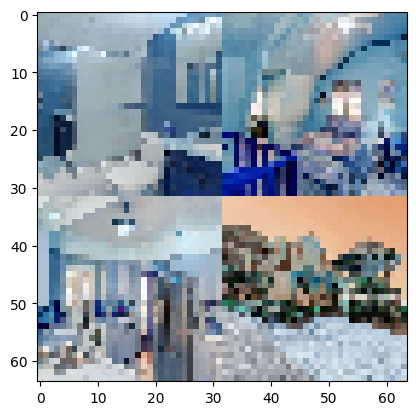

In [71]:
import matplotlib.pyplot as plt
plt.imshow(images[0])

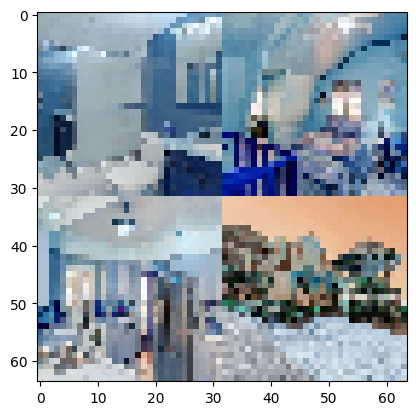

In [72]:

plt.imshow(outputImage)

In [73]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
print("[INFO] processing data...")
split = train_test_split(df, images, test_size=0.25, random_state=42)
(trainAttrX, testAttrX, trainImagesX, testImagesX) = split
# find the largest house price in the training set and use it to
# scale our house prices to the range [0, 1] (will lead to better
# training and convergence)
maxPrice = trainAttrX["price"].max()
trainY = trainAttrX["price"] / maxPrice
testY = testAttrX["price"] / maxPrice
# process the house attributes data by performing min-max scaling
# on continuous features, one-hot encoding on categorical features,
# and then finally concatenating them together
(trainAttrX, testAttrX) = process_house_attributes(df,
	trainAttrX, testAttrX)

[INFO] processing data...


In [74]:
df

,bedrooms,bathrooms,area,zipcode,price
30,5,3.0,2520,93446,789000
32,3,2.0,1802,93446,365000
39,3,3.0,2146,93446,455000
80,4,2.5,2464,91901,599000
81,2,2.0,1845,91901,529800
...,...,...,...,...,...
499,4,4.0,3000,93446,1495000
500,3,2.0,2330,93446,599900
501,3,2.5,1339,93446,344900
502,3,2.0,1472,93446,309995


In [75]:
trainAttrX[0]

array([0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.44444444, 0.45454545, 0.56262899])

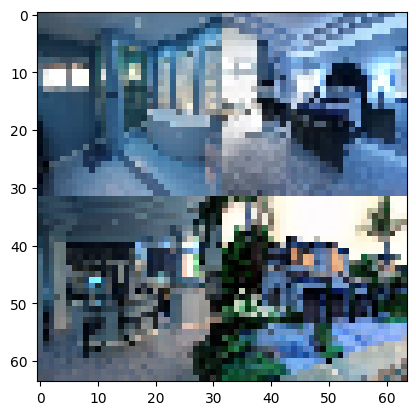

In [76]:
plt.imshow(trainImagesX[0])

In [77]:
trainY

148    0.323489
337    0.023045
444    0.107545
269    0.083476
362    0.013144
         ...   
181    0.083646
228    0.098839
412    0.023728
490    0.074940
212    0.102253
Name: price, Length: 271, dtype: float64

In [87]:
# create the MLP and CNN models
mlp = create_mlp(trainAttrX.shape[1:], regress=False)
cnn = create_cnn(64, 64, 3, regress=False)


In [88]:
mlp.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │            88 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124 (496.00 B)

 Trainable params: 124 (496.00 B)

 Non-trainable params: 0 (0.00 B)

In [89]:
cnn.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │        65,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,716 (350.45 KB)

 Trainable params: 89,460 (349.45 KB)

 Non-trainable params: 256 (1.00 KB)

In [90]:

# create the input to our final set of layers as the *output* of both
# the MLP and CNN
combinedInput = concatenate([mlp.output, cnn.output])
# our final FC layer head will have two dense layers, the final one
# being our regression head
x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)
# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted price of the house)
model = Model(inputs=[mlp.input, cnn.input], outputs=x)

In [92]:
# compile the model using mean absolute percentage error as our loss,
# implying that we seek to minimize the absolute percentage difference
# between our price *predictions* and the *actual prices*
opt = Adam(learning_rate=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)
# train the model
print("[INFO] training model...")
model.fit(
	x=[trainAttrX, trainImagesX], y=trainY,
	validation_data=([testAttrX, testImagesX], testY),
	epochs=200, batch_size=8)
# make predictions on the testing data
print("[INFO] predicting house prices...")
preds = model.predict([testAttrX, testImagesX])

[INFO] training model...
Epoch 1/200


c:\Users\Ort\miniconda3\envs\basic_env\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1106.0870 - val_loss: 244.3095
Epoch 2/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 520.0275 - val_loss: 235.5314
Epoch 3/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 402.5636 - val_loss: 153.1089
Epoch 4/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 296.2276 - val_loss: 166.3008
Epoch 5/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 234.2200 - val_loss: 176.4669
Epoch 6/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 174.4321 - val_loss: 423.7547
Epoch 7/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 134.2599 - val_loss: 1088.4045
Epoch 8/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 126.7864 - val_loss: 1672.4847
Epoch 9/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 102.5773 - val_loss: 1405.3374
Epoch 10/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 102.0773 - val_loss: 908.2679
Epoch 11/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 70.2829 - val_loss: 692.9717
Epoch 12/200
34/34

In [93]:
# compute the difference between the *predicted* house prices and the
# *actual* house prices, then compute the percentage difference and
# the absolute percentage difference
diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)
# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. house price: {}, std house price: {}".format(
	locale.currency(df["price"].mean(), grouping=True),
	locale.currency(df["price"].std(), grouping=True)))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] avg. house price: $533,388.27, std house price: $493,403.08
[INFO] mean: 23.08%, std: 20.69%


In [109]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error, mean_squared_error

In [110]:
r2_score(testY*maxPrice, preds*maxPrice)

0.7479798599617486

In [111]:
mean_absolute_percentage_error(testY*maxPrice, preds*maxPrice)

0.2308060851758251

In [112]:
mean_absolute_error(testY*maxPrice, preds*maxPrice)

113518.9721553378

In [113]:
np.sqrt(mean_squared_error(testY*maxPrice, preds*maxPrice))

175788.0014953587

In [115]:
np.sqrt(mean_squared_error(testY*maxPrice, preds*maxPrice))/(mean_absolute_error(testY*maxPrice, preds*maxPrice)+np.sqrt(mean_squared_error(testY*maxPrice, preds*maxPrice)))

0.6076175740844797